In [1]:
import numpy as np
import scipy.linalg
from data import load_data, get_data
from visualization import get_index_params, initialize_plot, add_sub_plot, remove_subplot  

In [2]:
def timer(funcion):
    """
    Se crea un decorador (googlear) del tipo timer para testear el tiempo
    de ejecucion del programa
    """
    def inner(*args, **kwargs):

        inicio = time.time()
        resultado = funcion(*args, **kwargs)
        final = round(time.time() - inicio, 3)
        print("\nTiempo de ejecucion total: {}[s]".format(final))

        return resultado
    return inner

In [3]:
def LASSO_FISTA(A, b, tau, iteracion_maxima, info = False):
    """
    Esta funcion recibe como input una matriz A y un vector b. Se busca resolver
    el problema de regulacion L1 con un parametro tau y haciendo un numero maximo
    de iteraciones definidas por el usuario, mediante el metodo del subgradiente.

    Su entrada posee:
        - A : Matriz de m muestras (filas) de cada variable n (columnas).
        - b : Matriz de m muestras obtenidas que depende de las n variables.
        - tau: Escalar que entrega significancia a las variables o entrega
               significancia al error del modelo (trade-off).
        - iteracion_maxima : Numero maximo de iteraciones a realizar.

    Su salida es:
        - valor_optimo : Valor optimo del problema a minimizar.
        - xk : Vector solucion del problema de k iteraciones."""
    
    # Lista de errores a retornar
    error_list = []

    # Se setean las dimensiones
    m, n = A.shape


    # Se setean las condiciones iniciales, junto a los vectores que almacenand
    # informacion de la iteracion k, k-1, k-2, respectivamente.
    xk = np.zeros((n, 1))


    # Se setea el segundo punto de sucesion (que le otorga el caracter de acelerado)
    zk = xk


    thetak = 1

    # Se setean el angulo que se forma entre las soluciones
    angulo = 0

    # Estimacion del valor de R (radio) y L (connstante de Lipschitz)
    # segun teoria vista en clases
    R = np.sqrt(np.linalg.norm(np.linalg.inv(np.dot(A, np.transpose(A)))))*np.linalg.norm(np.dot(np.transpose(A), b))
    L = tau*np.sqrt(n) + np.linalg.norm(np.dot(A, np.transpose(A)))*R + np.linalg.norm(np.dot(np.transpose(A), b))

    # Se calcula el valor optimo actual en la iteracion 0
    valor_optimo = tau*np.linalg.norm(xk, 1) + 0.5*np.linalg.norm(np.dot(A, xk) - b)**2

    # Se calcula la norma inifinito de b
    norma_b = np.linalg.norm(b)

    # Se despliega el mensaje en pantalla
    if info:
        print("\n\n**********    METODO FISTA    *********\n")
        print("ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1")

    # Se comienza el ciclo de iteraciones
    for iteracion in range(iteracion_maxima):
        # 1 Vector que se evalua en el gradiente para el paso xk+1
        yk = (1-thetak)*xk + thetak*zk

        # 2 Se actualizan los valores de almacenamiento


        # 3 Se crea el paso zk+1
        zk = zk - (2*np.dot(np.transpose(A), np.dot(A, yk) - b) + tau*np.sign(yk))/(thetak*L)

        # 4 Se crea el paso xk+1
        xk = (1 - thetak)*xk + thetak*zk

        # 5 Se actualiza la sucesion thetak se crean dos sucesiones para thethak
        # puedes testear cada una comentando la otra linea

        #thetak = 2/(1+np.sqrt(1+4/(thetak**2)))
        thetak = 2/(2+iteracion)

        # 6 Se actualiza el valor objetivo
        valor_optimo = tau*np.linalg.norm(xk, 1) + 0.5*np.linalg.norm(np.dot(A, xk) - b)**2

        # 7 Se calcula el error (segun norma infito de b) para mostrar en pantalla.
        error = np.linalg.norm(np.dot(A, xk) - b)/norma_b
        error_list.append(error)
        n1 = np.linalg.norm(xk, 1)
        

         # La rutina de FISTA muestra en pantalla para cada iteracion:
        # n de iteracion, valor de la funcion evaluada en el x de la iteracion,
        #  error y angulo formado por las soluciones.

        if info:
            retorno_en_pantalla = [iteracion, valor_optimo, error, n1]
            print("%12.6f %12.6f %12.6f %12.6f" % (retorno_en_pantalla[0],retorno_en_pantalla[1],retorno_en_pantalla[2],retorno_en_pantalla[3]))

    if not info:
        print(f"\n\n**********    METODO FISTA ÚLTIMA ITERACIÓN CON TAU = {tau} *********\n")
        print("ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1")
        retorno_en_pantalla = [iteracion, valor_optimo, error, n1]
        print("%12.6f %12.6f %12.6f %12.6f" % (retorno_en_pantalla[0],retorno_en_pantalla[1],retorno_en_pantalla[2],retorno_en_pantalla[3]))
        print_xsol_info(xk)

    return xk, error_list

In [4]:
def print_xsol_info(x, epsilon = 1e-2):
    print('Elementos no nulos: ' + str(np.where(abs(x) < abs(x).max() * epsilon, 0, 1).sum()))
    m = np.where(abs(x) < abs(x).max() * epsilon, 0, abs(x))
    print('Valor máximo xsol: ' + str(m.max()))
    print('Valor mínimo xsol: ' + str(np.min(m[np.nonzero(m)])))

In [5]:
def get_several_models(A, b, tau_list, iteracion_maxima, n_columns):
    # Obtenemos parámetros gráficos
    fig, axs, index = initialize_plot(y_size = 18, x_size = 20, n_sub_plots = len(tau_list), n_columns = n_columns)
    x = np.arange(iteracion_maxima)

    # Efectuamos Fista para diferentes Tau
    contador = 0
    for tau in tau_list:
        xsol, error_list = LASSO_FISTA(A, b, tau, iteracion_maxima)
        i, j = index[contador]
        add_sub_plot(axs, x, error_list, i, j, title = f'Tau = {tau}', x_label = 'Iteración', y_label = 'Error relativo')
        
        contador += 1

In [6]:
df = load_data('data.xlsx')
A, b = get_data(df)



**********    METODO FISTA ÚLTIMA ITERACIÓN CON TAU = 0 *********

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1
  999.000000     0.005989     0.011774    11.201196
Elementos no nulos: 1456
Valor máximo xsol: 0.029402442033835276
Valor mínimo xsol: 0.0002986707540860967


**********    METODO FISTA ÚLTIMA ITERACIÓN CON TAU = 1 *********

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1
  999.000000     5.538436     0.118488     4.931877
Elementos no nulos: 364
Valor máximo xsol: 0.06317917923590753
Valor mínimo xsol: 0.0006329372078161129


**********    METODO FISTA ÚLTIMA ITERACIÓN CON TAU = 2 *********

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1
  999.000000     9.757150     0.144583     4.427000
Elementos no nulos: 281
Valor máximo xsol: 0.07710878455186228
Valor mínimo xsol: 0.0007722891453284335


**********    METODO FISTA ÚLTIMA ITERACIÓN CON TAU = 3 *********

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1
  999.000000    13.706903     0.166442     4.17000

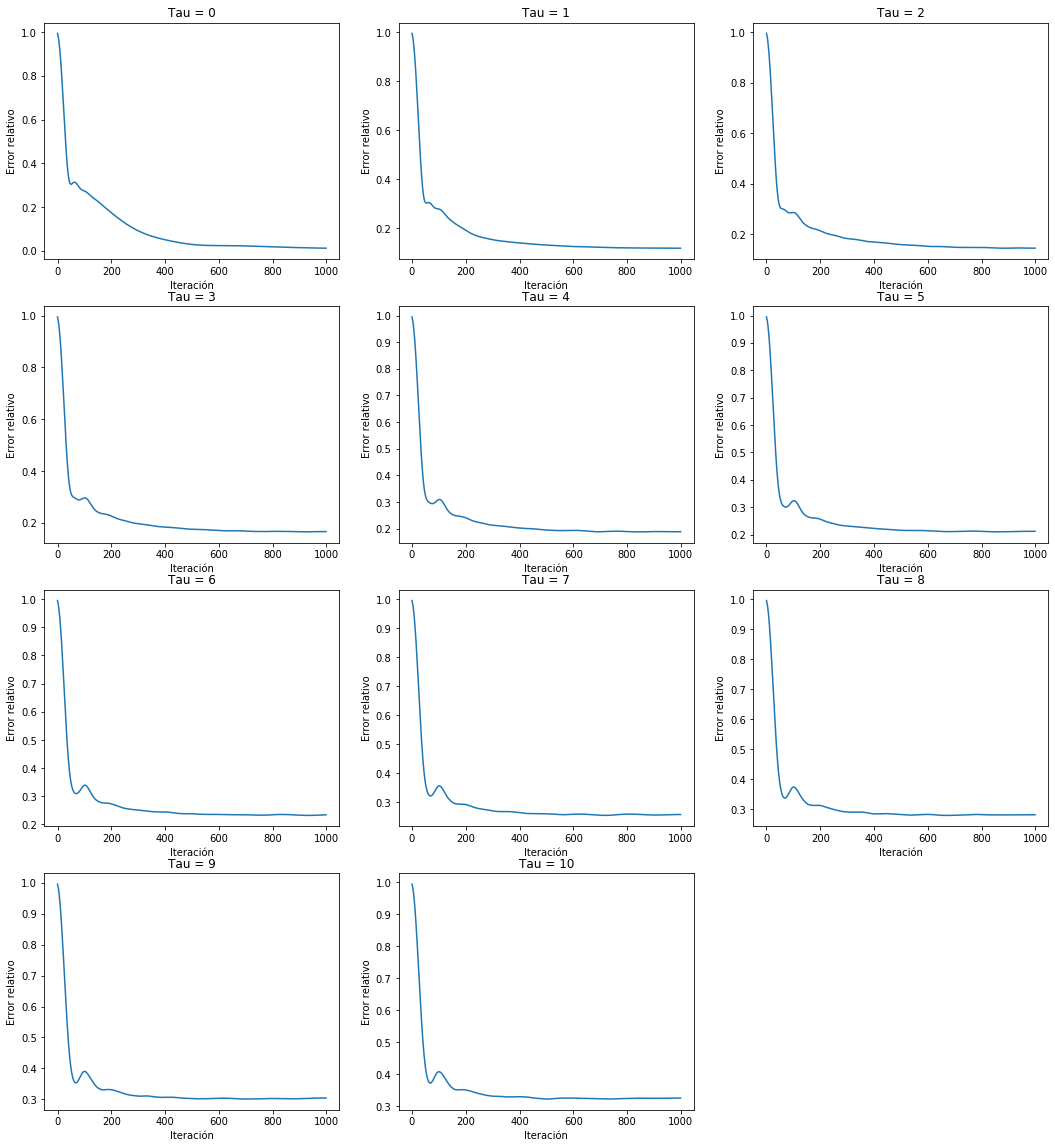

In [7]:
get_several_models(A, b, [i for i in range(11)], 1000, 3)